In [1]:
! nvidia-smi

Thu Nov  3 22:43:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    30W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
! pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 13.9 MB/s 
     |████████████████████████████████| 163 kB 56.6 MB/s 
     |████████████████████████████████| 115 kB 61.5 MB/s 
     |████████████████████████████████| 95 kB 1.9 MB/s 
     |████████████████████████████████| 212 kB 52.7 MB/s 
     |████████████████████████████████| 127 kB 52.1 MB/s 
     |████████████████████████████████| 115 kB 20.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: dill
    Found existing installation: dill 0.3.6
    Uninstalling dill-0.3.6:
      Successfully uninstalled dill-0.3.6


In [3]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 14.9 MB/s 
     |████████████████████████████████| 7.6 MB 53.4 MB/s 


In [4]:
from datasets import load_dataset
from datasets import load_metric
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from transformers import AutoModelForQuestionAnswering
from transformers import AutoConfig
from functools import partial
import torch
import torch.nn.functional as F
import random
import numpy as np
import collections
from tqdm.autonotebook import tqdm
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from transformers import RobertaTokenizer, RobertaForTokenClassification
from torch.optim.lr_scheduler import LambdaLR
from torch import nn
from collections import defaultdict, OrderedDict
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from matplotlib import pyplot as plt

In [5]:
MODEL_NAME = "cardiffnlp/twitter-roberta-base-emotion"

epochs = 3
batch_size = 4
lr = 2e-5

num_labels = 3

weight_decay = 0.01
warmup_steps = 200

max_length = 512  # 输入feature的最大长度，question和context拼接之后
doc_stride = 128  # 2个切片之间的重合token数量。
pad_on_right = True

train_language = ["english"]
val_language = ["english"]

In [6]:
def enforce_reproducibility(seed=42):
    # Sets seed manually for both CPU and CUDA
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # For atomic operations there is currently 
    # no simple way to enforce determinism, as
    # the order of parallel operations is not known.
    # CUDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # System based
    random.seed(seed)
    np.random.seed(seed)

device = torch.device("cpu")
if torch.cuda.is_available():
  device = torch.device("cuda")

enforce_reproducibility()

In [7]:
# this is also equivalent to those 2 lines. I recommend going with that, unless you want more control over your code
from datasets import load_metric
compute_squad = load_metric("squad_v2")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/768 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [9]:
def get_answer_index(start_index, offset_mapping):
    res = -1
    for i, t in enumerate(offset_mapping):
        if t[0] <= start_index and t[1] >= start_index:
            res = i
    return res


def get_start_and_end_answer_index(start_index, end_index, offset_mapping):
    start_res = -1
    end_res = -1
    for i, t in enumerate(offset_mapping):
        if t[0] <= start_index and t[1] >= start_index:
            start_res = i
        if t[0] <= end_index and t[1] >= end_index:
            end_res = i
    return (start_res, end_res)


def get_train_features(examples):
    # 既要对examples进行truncation（截断）和padding（补全）还要还要保留所有信息，所以要用的切片的方法。
    # 每一个一个超长文本example会被切片成多个输入，相邻两个输入之间会有交集。
    tokenized_examples = tokenizer(
        examples["question_text" if pad_on_right else "document_plaintext"],
        examples["document_plaintext" if pad_on_right else "question_text"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # 我们使用overflow_to_sample_mapping参数来映射切片片ID到原始ID。
    # 比如有2个expamples被切成4片，那么对应是[0, 0, 1, 1]，前两片对应原来的第一个example。
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # offset_mapping也对应4片
    # offset_mapping参数帮助我们映射到原始输入，由于答案标注在原始输入上，所以有助于我们找到答案的起始和结束位置。
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # 重新标注数据
    tokenized_examples["labels"] = []

    for i, offsets in enumerate(offset_mapping):
        # 对每一片进行处理
        # 将无答案的样本标注到CLS上
        input_ids = tokenized_examples["input_ids"][i]

        # 区分question和context
        sequence_ids = tokenized_examples.sequence_ids(i)

        # 拿到原始的example 下标.
        sample_index = sample_mapping[i]
        answers = examples["annotations"][sample_index]
        # 如果没有答案，则使用CLS所在的位置为答案.
        if len(answers["answer_start"]) == [-1]:
            tokenized_examples["labels"].append([0] * max_length)
        else:
            # 答案的character级别Start/end位置.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["answer_text"][0])

            # 找到token级别的index start.
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            # 找到token级别的index end.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1
            # 检测答案是否超出文本长度，超出的话也适用CLS index作为标注.
            temp = [0] * max_length
            if offsets[token_start_index][0] > start_char or offsets[token_end_index][1] < end_char:
                tokenized_examples["labels"].append(temp)
            elif offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char:
                s, e = get_start_and_end_answer_index(start_char, end_char, offsets)
                temp[s] = 1
                temp[s + 1:e + 1] = [2] * (e - s)
                tokenized_examples["labels"].append(temp)
            elif offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] < end_char:
                s = get_answer_index(start_char, offsets)
                temp[s] = 1
                length = len(temp) - s
                temp[s:] = [2] * length
                tokenized_examples["labels"].append(temp)
            elif offsets[token_start_index][0] > start_char and offsets[token_end_index][1] >= end_char:
                e = get_answer_index(end_char, offsets)
                temp[:e + 1] = [2] * e
                tokenized_examples["labels"].append(temp)
    return tokenized_examples

In [10]:
def collate_fn(inputs):
    '''
    Defines how to combine different samples in a batch
    '''
    input_ids = torch.tensor([i['input_ids'] for i in inputs])
    attention_mask = torch.tensor([i['attention_mask'] for i in inputs])
    labels = torch.tensor([i['labels'] for i in inputs])
    # no_answer_probability = torch.tensor([i['no_answer_probability'] for i in inputs])

    # Truncate to max length
    max_len = max(attention_mask.sum(-1))
    input_ids = input_ids[:, :max_len]
    attention_mask = attention_mask[:, :max_len]
    labels = labels[:, :max_len]

    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}

In [11]:
def get_validation_features(samples):
    # First, tokenize the text. We get the offsets and return overflowing sequences in
    # order to break up long sequences into multiple inputs. The offsets will help us
    # determine the original answer text
    batch = tokenizer(
        samples["question_text" if pad_on_right else "document_plaintext"],
        samples["document_plaintext" if pad_on_right else "question_text"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # We'll store the ID of the samples to calculate squad score
    batch['example_id'] = []

    # batch['no_answer_probability'] = []

    # The overflow sample map tells us which input each sample corresponds to
    sample_map = batch.pop('overflow_to_sample_mapping')

    for i in range(len(batch['input_ids'])):
        # The sample index tells us which of the values in "samples" these features belong to
        sample_idx = sample_map[i]
        sequence_ids = batch.sequence_ids(i)

        # Add the ID to map these features back to the correct sample
        batch['example_id'].append(samples['id'][sample_idx])

        # Set offsets for non-context words to be None for ease of processing
        batch['offset_mapping'][i] = [o if sequence_ids[k] == 1 else None for k, o in
                                      enumerate(batch['offset_mapping'][i])]

        # # no answer probability
        # ans = samples['annotations'][sample_idx]
        # if ans['answer_start'] == [-1]:
        #     no_answer_probability = 1
        # else:
        #     no_answer_probability = 0

        # batch['no_answer_probability'].append(no_answer_probability)

    return batch

def val_collate_fn(inputs):
    input_ids = torch.tensor([i['input_ids'] for i in inputs])
    attention_mask = torch.tensor([i['attention_mask'] for i in inputs])
    # no_answer_probability = torch.tensor([i['no_answer_probability'] for i in inputs])


    # Truncate to max length
    max_len = max(attention_mask.sum(-1))
    input_ids = input_ids[:, :max_len]
    attention_mask = attention_mask[:, :max_len]

    return {'input_ids': input_ids, 'attention_mask': attention_mask}

In [12]:
def post_process_predictions(examples, dataset, logits, num_possible_answers=20, max_answer_length=30):
    all_labels = logits
    
    # Build a map from example to its corresponding features. This will allow us to index from
    # sample ID to all of the features for that sample (in case they were split up due to long input)
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = defaultdict(list)
    for i, feature in enumerate(dataset):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # Create somewhere to store our predictions
    predictions = OrderedDict()

    # Iterate through each sample in the dataset
    for j, sample in enumerate(tqdm(examples)):

        # Get the feature indices (all of the features split across the batch)
        feature_indices = features_per_example[j]
        
        
        # Get the original context which predumably has the answer text
        context = tokenizer(sample['document_plaintext'])
        print(context)
        print(np.shape(context['input_ids']))

        preds = []
        # Iterate through all of the features
        for ft_idx in feature_indices:
            each_label = []
            label_logits = all_labels[ft_idx]
            for label_pos in range(len(label_logits)):
                pos = np.argmax(label_logits[label_pos])
                each_label.append(pos)
        print(each_label)
        print(np.shape(each_label))
        break

        if len(preds) > 0:
            # Sort by score to get the top answer
            answer = sorted(preds, key=lambda x: x['score'], reverse=True)[0]
        else:
            answer = {'score': 0.0, 'text': ""}

        predictions[sample['id']] = answer['text']
    return predictions

In [13]:
def getLanguageDataSet(data, language):
    def printAndL(x):
        return x["language"] in language

    return data.filter(printAndL)

In [14]:
def process_train_data(language):
    dataset = load_dataset("copenlu/answerable_tydiqa")
    dataset = getLanguageDataSet(dataset, language)['train']
    dataset = dataset.remove_columns("language")
    dataset = dataset.remove_columns("document_url")

    tokenized_dataset = dataset.map(get_train_features, batched=True, remove_columns=dataset.column_names)
    return tokenized_dataset

def process_validation_data(language):
    dataset = load_dataset("copenlu/answerable_tydiqa")
    dataset = getLanguageDataSet(dataset, language)['validation']
    dataset = dataset.remove_columns("language")
    dataset = dataset.remove_columns("document_url")
    ids = [i for i in range(len(dataset['question_text']))]
    dataset = dataset.add_column('id',ids)

    tokenized_dataset = dataset.map(get_validation_features, batched=True, remove_columns=dataset.column_names)
    return tokenized_dataset

In [15]:
def train(
    model: nn.Module, 
    train_dl: DataLoader, 
    optimizer: torch.optim.Optimizer, 
    schedule: LambdaLR,
    n_epochs: int, 
    device: torch.device
):
  """
  The main training loop which will optimize a given model on a given dataset
  :param model: The model being optimized
  :param train_dl: The training dataset
  :param optimizer: The optimizer used to update the model parameters
  :param n_epochs: Number of epochs to train for
  :param device: The device to train on
  """

  # Keep track of the loss and best accuracy
  losses = []
  best_acc = 0.0
  pcounter = 0

  # Iterate through epochs
  for ep in range(n_epochs):

    loss_epoch = []

    #Iterate through each batch in the dataloader
    for batch in tqdm(train_dl):
      # VERY IMPORTANT: Make sure the model is in training mode, which turns on 
      # things like dropout and layer normalization
      model.train()

      # VERY IMPORTANT: zero out all of the gradients on each iteration -- PyTorch
      # keeps track of these dynamically in its computation graph so you need to explicitly
      # zero them out
      optimizer.zero_grad()

      # Place each tensor on the GPU
      batch = {b: batch[b].to(device) for b in batch}

      # Pass the inputs through the model, get the current loss and logits
      outputs = model(
          input_ids=batch['input_ids'],
          attention_mask=batch['attention_mask'],
          labels=batch['labels']
      )

      loss = outputs['loss']
      losses.append(loss.item())
      loss_epoch.append(loss.item())
      
      # Calculate all of the gradients and weight updates for the model
      loss.backward()

      # Optional: clip gradients
      #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Finally, update the weights of the model and advance the LR schedule
      optimizer.step()
      scheduler.step()
      #gc.collect()
  return losses

In [16]:
def predict(model: nn.Module, valid_dl: DataLoader):
    """
    Evaluates the model on the given dataset
    :param model: The model under evaluation
    :param valid_dl: A `DataLoader` reading validation data
    :return: The accuracy of the model on the dataset
    """
    # VERY IMPORTANT: Put your model in "eval" mode -- this disables things like
    # layer normalization and dropout
    model.eval()
    labels = []
    # no_answer_probability_logits_all = []

    # ALSO IMPORTANT: Don't accumulate gradients during this process
    with torch.no_grad():
        for batch in tqdm(valid_dl, desc='Evaluation'):
            batch = {b: batch[b].to('cuda') for b in batch}

            # Pass the inputs through the model, get the current loss and logits
            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask']
            )
            # Store the "start" class logits and "end" class logits for every token in the input
            labels.extend(list(outputs['logits'].detach().cpu().numpy()))
            # no_answer_probability_logits_all.extend(list(F.sigmoid(classify_labels[:,1]).detach().cpu().numpy()))            

        return labels

In [17]:
tokenized_train_dataset = process_train_data(train_language)

train_dl = DataLoader(tokenized_train_dataset, collate_fn=collate_fn, shuffle=True, batch_size=batch_size)


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/copenlu___parquet/copenlu--nlp_course_tydiqa-9ffd3d37cf2899c6/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?ba/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

In [18]:
model = RobertaForTokenClassification.from_pretrained(MODEL_NAME, num_labels=num_labels, problem_type="multi_label_classification").to(device)

model

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-emotion were not used when initializing RobertaForTokenClassification: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-st

RobertaForTokenClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm

In [19]:
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
     'weight_decay': weight_decay},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    warmup_steps,
    epochs * len(train_dl)
)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [20]:
losses = train(
    model,
    train_dl,
    optimizer,
    scheduler,
    epochs,
    device
)

  0%|          | 0/1871 [00:00<?, ?it/s]

  0%|          | 0/1871 [00:00<?, ?it/s]

  0%|          | 0/1871 [00:00<?, ?it/s]

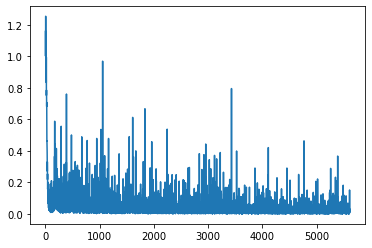

In [21]:
plt.cla()
plt.plot(losses)


In [22]:
tokenized_val_dataset = process_validation_data(val_language)
example_val = load_dataset("copenlu/answerable_tydiqa")
example_val = getLanguageDataSet(example_val, val_language)['validation']

ids = [i for i in range(len(example_val['question_text']))]
example_val = example_val.add_column('id',ids)


  0%|          | 0/2 [00:00<?, ?it/s]

Flattening the indices:   0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Flattening the indices:   0%|          | 0/1 [00:00<?, ?ba/s]

In [23]:
val_dl = DataLoader(tokenized_val_dataset, collate_fn=val_collate_fn, shuffle=False, batch_size=batch_size)
logits = predict(model, val_dl)


Evaluation:   0%|          | 0/250 [00:00<?, ?it/s]

In [24]:
id_list = []
answer_list = []

for example in example_val:
    id_list.append(example['id'])
    answer_list.append(example['annotations'])

for mydict in answer_list:
    mydict['text'] = mydict.pop('answer_text')

print(id_list[:10])
print(answer_list[:10])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[{'answer_start': [51], 'text': ['cleaning and protection from reinjury or infection']}, {'answer_start': [0], 'text': ['Brothers Amos and Wilfrid Ayre']}, {'answer_start': [295], 'text': ['2.3–2.8mm']}, {'answer_start': [352], 'text': ['December 1988']}, {'answer_start': [32], 'text': ['1939']}, {'answer_start': [48], 'text': ['1912']}, {'answer_start': [109], 'text': ['2 billion']}, {'answer_start': [59], 'text': ['923']}, {'answer_start': [253], 'text': ['9 September 1923']}, {'answer_start': [208], 'text': ['6 June 1944']}]


In [25]:
predictions = post_process_predictions(example_val, tokenized_val_dataset, logits)

  0%|          | 0/990 [00:00<?, ?it/s]

{'input_ids': [0, 771, 9834, 575, 11620, 8, 9706, 7725, 11759, 1241, 8143, 8, 2591, 31, 9493, 38160, 50, 7910, 4, 22606, 15, 349, 3186, 18, 782, 6, 24, 64, 1186, 31, 5, 31625, 78, 2887, 7, 1445, 8701, 780, 23664, 215, 25, 7725, 6, 29122, 13604, 6, 8, 39077, 4086, 8701, 8, 7403, 1312, 575, 4, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
(56,)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [26]:
predictions = post_process_predictions(example_val, tokenized_val_dataset, logits)
formatted_predictions = [{'id': k, 'prediction_text': v[0], 'no_answer_probability': v[1]} for k, v in predictions.items()]
gold = [{'id': id_list[i], 'answers': answer_list[i]} for i in range(len(id_list))]

  0%|          | 0/990 [00:00<?, ?it/s]

{'input_ids': [0, 771, 9834, 575, 11620, 8, 9706, 7725, 11759, 1241, 8143, 8, 2591, 31, 9493, 38160, 50, 7910, 4, 22606, 15, 349, 3186, 18, 782, 6, 24, 64, 1186, 31, 5, 31625, 78, 2887, 7, 1445, 8701, 780, 23664, 215, 25, 7725, 6, 29122, 13604, 6, 8, 39077, 4086, 8701, 8, 7403, 1312, 575, 4, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
(56,)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [27]:
formatted_predictions[:10]

[]

In [28]:
gold[:10]

[{'id': 0,
  'answers': {'answer_start': [51],
   'text': ['cleaning and protection from reinjury or infection']}},
 {'id': 1,
  'answers': {'answer_start': [0],
   'text': ['Brothers Amos and Wilfrid Ayre']}},
 {'id': 2, 'answers': {'answer_start': [295], 'text': ['2.3–2.8mm']}},
 {'id': 3, 'answers': {'answer_start': [352], 'text': ['December 1988']}},
 {'id': 4, 'answers': {'answer_start': [32], 'text': ['1939']}},
 {'id': 5, 'answers': {'answer_start': [48], 'text': ['1912']}},
 {'id': 6, 'answers': {'answer_start': [109], 'text': ['2 billion']}},
 {'id': 7, 'answers': {'answer_start': [59], 'text': ['923']}},
 {'id': 8, 'answers': {'answer_start': [253], 'text': ['9 September 1923']}},
 {'id': 9, 'answers': {'answer_start': [208], 'text': ['6 June 1944']}}]

In [29]:
compute_squad.compute(references=gold, predictions=formatted_predictions)


ZeroDivisionError: ignored